# Torneo SNA 2025

* Nombre equipo:
  * 3DIC
* Participantes:
  * Paula Corral rebollar
  * Lucía Cuevas Serrano

# Instalar dependencias

In [12]:
!pip install torch_geometric

#!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)")+.html
import warnings
warnings.filterwarnings("ignore", message="The usage of `scatter")


# Cargar el dataset

In [13]:
import json
import networkx as nx
import os
import os.path as osp
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.utils.convert import from_networkx
from zipfile import ZipFile

class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/WTBtQ3HH2GjpGAi/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        self.train_idx = torch.load(self.processed_paths[1], weights_only=False)
        self.test_idx = torch.load(self.processed_paths[2], weights_only=False)

    @property
    def raw_file_names(self):
        return ['nx_graphs.zip']

    @property
    def processed_file_names(self):
        return ['geometric_data_processed.pt', "train_idx.pt", "test_idx.pt"]

    @property
    def num_classes(self):
        return 1

    @property
    def num_features(self):
        return 9

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='nx_graphs.zip')

    def process(self):

        with ZipFile(self.raw_paths[0], 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)

        data_list = []
        train_idx = []
        test_idx = []
        for f in os.listdir(osp.join(self.raw_dir, "nx_graphs")):
            G = nx.read_gml(osp.join(self.raw_dir, "nx_graphs", f))
            data = from_networkx(G)
            data.x = data.x.float()

            data.nid = torch.tensor([G.graph["molecule_id"]], dtype=torch.long)
            data_list.append(data)

            if G.graph["set"] == "training":
                data.y = torch.tensor([G.graph["y"]], dtype=torch.float)
                train_idx.append(G.graph["molecule_id"])
            else:
                data.y = torch.tensor([torch.nan], dtype=torch.float)
                test_idx.append(G.graph["molecule_id"])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data_list.sort(key=lambda x: x.nid.item())

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        torch.save(train_idx, self.processed_paths[1])
        torch.save(test_idx, self.processed_paths[2])

Number of molecules: 4200
Number of node attributes: 9
Example Graph: Data(x=[22, 9], edge_index=[2, 50], y=[1], molecule_id=[1], set='training', nid=[1])
Training set size: 3360
Test set size: 840
Trainning distribution: count    3360.000000
mean        2.200554
std         1.199276
min        -1.500000
25%         1.437500
50%         2.360000
75%         3.100000
max         4.500000
dtype: float64
Test distribution: Counter({'nan': 840})


Text(0.5, 1.0, 'Histogram of training labels')

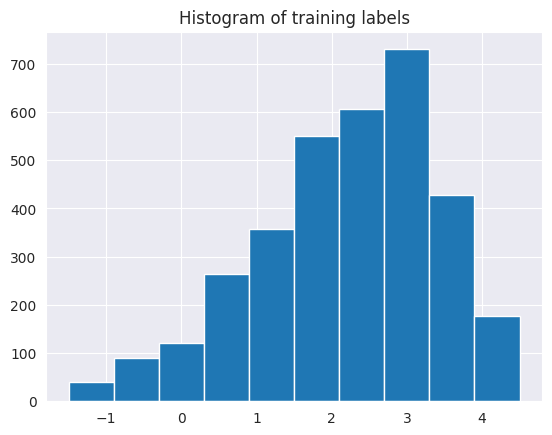

In [14]:
from collections import Counter
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

dataset = TournamentDataset(root='tournament')

print(f"Number of molecules: {len(dataset)}")
print(f"Number of node attributes: {dataset.num_features}")
print(f"Example Graph: {dataset[0]}")
print(f"Training set size: {len(dataset.train_idx)}")
print(f"Test set size: {len(dataset.test_idx)}")
print(f"Trainning distribution: {pd.Series([dataset[i].y.item() for i in dataset.train_idx]).describe()}")
print(f"Test distribution: {Counter([str(dataset[i].y.item()) for i in dataset.test_idx])}")

pd.Series([dataset[i].y.item() for i in dataset.train_idx]).hist()
plt.title("Histogram of training labels")

# Dividir datos

El split previo de este cuaderno era así:
![Split previo](split_previo.png)

In [15]:
import numpy as np
import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import WeightedRandomSampler

# Índices y targets
train_indices = np.array(dataset.train_idx)
y_values = np.array([dataset[i].y.item() for i in train_indices])

# Binning para estratificación
n_bins = 10
bins, bin_edges = pd.qcut(y_values, q=n_bins, duplicates="drop", retbins=True)
bins = bins.codes

# Split estratificado
train_idx, val_idx = train_test_split(
    train_indices, test_size=0.15, stratify=bins, random_state=42
)

# Calcular pesos inversos por bin
train_targets = np.array([dataset[i].y.item() for i in train_idx])
train_bins = pd.cut(train_targets, bins=bin_edges, include_lowest=True)

bin_counts = train_bins.value_counts().sort_index()
bin_weights = 1.0 / bin_counts
bin_weights /= bin_weights.mean()  # normalizar

# Crear array de pesos por sample
sample_weights = np.array([bin_weights.iloc[code] for code in train_bins.codes])
sample_weights = torch.tensor(sample_weights, dtype=torch.float)

# WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders
train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=128, sampler=sampler)
val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=len(val_idx), shuffle=False)

print("Train size:", len(train_idx))
print("Validation size:", len(val_idx))


Train size: 2856
Validation size: 504


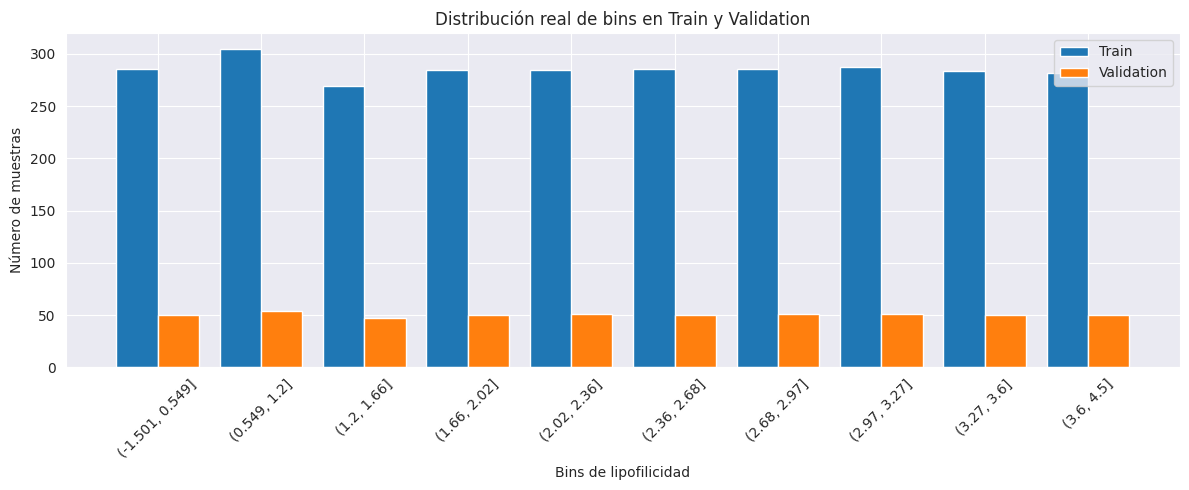

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Todos los labels de training original
all_y = np.array([dataset[i].y.item() for i in dataset.train_idx])

# Bin edges consistentes
bin_edges = pd.qcut(
    all_y, q=n_bins, duplicates="drop", retbins=True
)[1]

# Train (sin oversampling)
train_y = np.array([dataset[i].y.item() for i in train_idx])
train_bins = pd.cut(train_y, bins=bin_edges, include_lowest=True)
train_counts = train_bins.value_counts().sort_index()

# Validation
val_y = np.array([dataset[i].y.item() for i in val_idx])
val_bins = pd.cut(val_y, bins=bin_edges, include_lowest=True)
val_counts = val_bins.value_counts().sort_index()

# Barplot
x = np.arange(len(train_counts))
width = 0.4

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_counts.values, width, label="Train")
plt.bar(x + width/2, val_counts.values, width, label="Validation")

plt.xticks(x, [str(interval) for interval in train_counts.index], rotation=45)
plt.xlabel("Bins de lipofilicidad")
plt.ylabel("Número de muestras")
plt.title("Distribución real de bins en Train y Validation")
plt.legend()
plt.tight_layout()
plt.show()


# Definir modelo

In [17]:
from torch.nn import Module
import torch
from torch_geometric.nn import (
    GINConv,
    global_mean_pool,
    global_max_pool,
    BatchNorm
)

class GINGraph(Module):

    def __init__(self, num_features, num_classes, hidden_channels=256, n_layers=4, dropout=0.25):
        super().__init__()

        self.dropout = dropout

        # Proyección inicial
        self.input_proj = torch.nn.Linear(num_features, hidden_channels)
        self.input_norm = torch.nn.BatchNorm1d(hidden_channels)

        # Capas GIN con residual
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        for _ in range(n_layers):
            mlp = torch.nn.Sequential(
                torch.nn.Linear(hidden_channels, hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_channels, hidden_channels)
            )
            self.convs.append(GINConv(mlp, train_eps=True))
            self.norms.append(BatchNorm(hidden_channels))

        # Pooling mean + max
        self.pool_dim = hidden_channels * 2

        # MLP a nivel de grafo
        self.pool_mlp = torch.nn.Sequential(
            torch.nn.Linear(self.pool_dim, hidden_channels),
            torch.nn.LeakyReLU(0.1),
            torch.nn.LayerNorm(hidden_channels),
            torch.nn.Dropout(dropout),

            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.LeakyReLU(0.1),
            torch.nn.LayerNorm(hidden_channels),
            torch.nn.Dropout(dropout),

            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.LeakyReLU(0.1),
            torch.nn.LayerNorm(hidden_channels // 2),
            torch.nn.Dropout(dropout)
        )

        self.regressor = torch.nn.Linear(hidden_channels // 2, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Proyección inicial
        x = self.input_proj(x)
        x = self.input_norm(x)

        # GIN profundo con residual
        for conv, norm in zip(self.convs, self.norms):
            h = conv(x, edge_index)
            h = norm(h)
            h = torch.nn.functional.leaky_relu(h, 0.1)
            h = torch.nn.functional.dropout(h, p=self.dropout, training=self.training)
            x = torch.nn.functional.layer_norm(x + h, x.size()[1:])

        # Pooling
        x = torch.cat(
            [global_mean_pool(x, batch), global_max_pool(x, batch)],
            dim=1
        )

        # MLP de grafo
        x = self.pool_mlp(x)

        # Regresión
        out = self.regressor(x)
        out = torch.clamp(out, min=-3.0, max=7.0)
        return out


# Entrenar el modelo

In [18]:
import torch
from sklearn.metrics import mean_squared_error

def loss_fn(y_pred, y_true):
    return torch.nn.functional.mse_loss(y_pred, y_true)


def train_epoch():
  model.train()
  total_loss = 0.0

  y_true_all = []
  y_pred_all = []

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()

    y_true = data.y.view(-1)
    y_pred = model(data).view(-1)

    loss = loss_fn(y_pred, y_true)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    y_true_all.extend(y_true.detach().cpu().numpy())
    y_pred_all.extend(y_pred.detach().cpu().numpy())

  avg_loss = total_loss / len(train_loader)
  rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

  return avg_loss, rmse

def validate_epoch():
    model.eval()
    total_loss = 0.0

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            y_true = data.y.view(-1)
            y_pred = model(data).view(-1)

            loss = loss_fn(y_pred, y_true)
            total_loss += loss.item()

            y_true_all.extend(y_true.cpu().numpy())
            y_pred_all.extend(y_pred.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

    return avg_loss, rmse

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GINGraph(dataset.num_features, 1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=300,
    eta_min=1e-6
)

num_epochs=1001
train_losses, train_rmses, val_losses, val_rmses = [], [], [], []

# Criterio de parada
patience = 250
best_val_rmse = float('inf')
epochs_no_improve = 0
best_model_epoch = 0

# Entrenar

for epoch in range(num_epochs):
    train_loss, train_rmse = train_epoch()
    val_loss, val_rmse = validate_epoch()
    scheduler.step()

    train_losses.append(train_loss)
    train_rmses.append(train_rmse)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model_state = model.state_dict()
        best_model_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        model.load_state_dict(best_model_state)
        break

model.load_state_dict(best_model_state)
best_train_loss = train_losses[best_model_epoch]
best_train_rmse = train_rmses[best_model_epoch]
best_val_loss = val_losses[best_model_epoch]
best_val_rmse = val_rmses[best_model_epoch]

print(
    f"Best model at epoch {best_model_epoch} | "
    f"Train Loss: {best_train_loss:.4f}, Train RMSE: {best_train_rmse:.4f} | "
    f"Val Loss: {best_val_loss:.4f}, Val RMSE: {best_val_rmse:.4f}"
)


Epoch 000 | Train Loss: 1.8918, Train RMSE: 1.3851 | Val Loss: 1.4563, Val RMSE: 1.2068
Epoch 010 | Train Loss: 0.8179, Train RMSE: 0.9038 | Val Loss: 1.5853, Val RMSE: 1.2591
Epoch 020 | Train Loss: 0.5176, Train RMSE: 0.7183 | Val Loss: 0.5664, Val RMSE: 0.7526
Epoch 030 | Train Loss: 0.4579, Train RMSE: 0.6753 | Val Loss: 0.4580, Val RMSE: 0.6767
Epoch 040 | Train Loss: 0.3399, Train RMSE: 0.5821 | Val Loss: 0.3981, Val RMSE: 0.6310
Epoch 050 | Train Loss: 0.3078, Train RMSE: 0.5569 | Val Loss: 0.6481, Val RMSE: 0.8050
Epoch 060 | Train Loss: 0.2715, Train RMSE: 0.5212 | Val Loss: 0.4142, Val RMSE: 0.6436
Epoch 070 | Train Loss: 0.2384, Train RMSE: 0.4882 | Val Loss: 0.4114, Val RMSE: 0.6414
Epoch 080 | Train Loss: 0.2343, Train RMSE: 0.4816 | Val Loss: 0.4510, Val RMSE: 0.6716
Epoch 090 | Train Loss: 0.2166, Train RMSE: 0.4650 | Val Loss: 0.4073, Val RMSE: 0.6382
Epoch 100 | Train Loss: 0.1925, Train RMSE: 0.4364 | Val Loss: 0.3531, Val RMSE: 0.5943
Epoch 110 | Train Loss: 0.1840, 

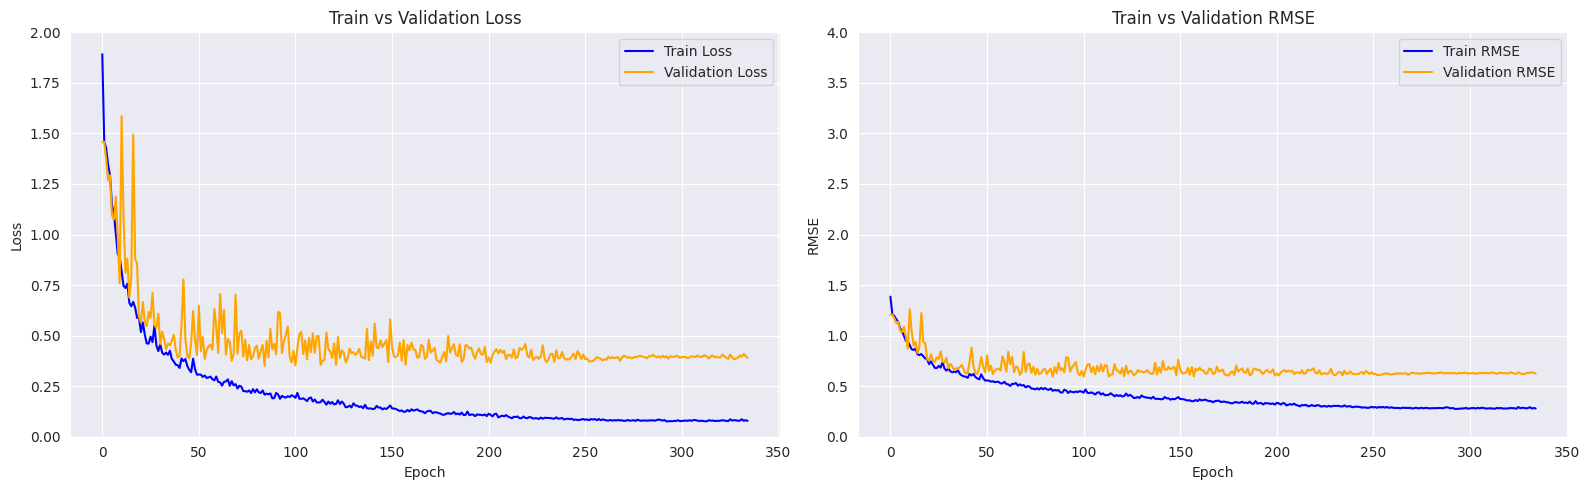

In [19]:
import numpy as np
import matplotlib.pyplot as plt

epochs = range(len(train_losses))
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(epochs, train_losses, label="Train Loss", color="blue")
axes[0].plot(epochs, val_losses, label="Validation Loss", color="orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train vs Validation Loss")
axes[0].set_ylim([0, 2])
axes[0].legend()
axes[0].grid(True)

# RMSE
axes[1].plot(epochs, train_rmses, label="Train RMSE", color="blue")
axes[1].plot(epochs, val_rmses, label="Validation RMSE", color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("RMSE")
axes[1].set_title("Train vs Validation RMSE")
axes[1].set_ylim([0, 4])
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [23]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import copy

# 1. Función de pérdida y entrenamiento (se mantienen casi igual)
def loss_fn(y_pred, y_true):
    #return torch.nn.functional.huber_loss(y_pred.float(), y_true.float(), delta=1.0)
    return torch.nn.functional.mse_loss(y_pred.float(), y_true.float())


def train_one_epoch(model, train_loader, optimizer, device):
  model.train()
  total_loss = 0.0

  y_true_all = []
  y_pred_all = []

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()

    y_true = data.y.view(-1)
    y_pred = model(data).view(-1)

    loss = loss_fn(y_pred, y_true)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    y_true_all.extend(y_true.detach().cpu().numpy())
    y_pred_all.extend(y_pred.detach().cpu().numpy())

  avg_loss = total_loss / len(train_loader)
  rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

  return avg_loss, rmse

def validate_one_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0.0

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            y_true = data.y.view(-1)
            y_pred = model(data).view(-1)

            loss = loss_fn(y_pred, y_true)
            total_loss += loss.item()

            y_true_all.extend(y_true.cpu().numpy())
            y_pred_all.extend(y_pred.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

    return avg_loss, rmse


def run_training_session(train_loader, val_loader, device, num_epochs=1000, patience=50):
    model = GINGraph(dataset.num_features, 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs,eta_min=1e-6)
    
    best_val_rmse = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    best_model_epoch = 0

    
    for epoch in range(num_epochs):
        train_loss, train_rmse = train_one_epoch(model, train_loader, optimizer, device)
        val_loss, val_rmse = validate_one_epoch(model, val_loader, device)
        
        scheduler.step()
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            best_model_epoch = epoch
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f"Terminado por paciencia en época {epoch}")
            break
            
    return best_model_epoch, best_val_rmse, best_model_state



device = "cuda" if torch.cuda.is_available() else "cpu"
num_runs = 5         # Número de intentos aleatorios
num_epochs = 1001     # Épocas por intento
patience = 250        # Paciencia

best_overall_rmse = float('inf')
best_overall_state = None
results = []


for i in range(num_runs):
    epoch, rmse, state = run_training_session(train_loader, val_loader, device,num_epochs,patience)

    print(f" Execution {i}: Best model at epoch {epoch}, Val RMSE: {rmse}")
    
    results.append(rmse)
    
    if rmse < best_overall_rmse:
        best_overall_rmse = rmse
        best_global_state = state
        

# Guardar y cargar el ganador
model = GINGraph(dataset.num_features, 1).to(device)
model.load_state_dict(best_global_state)
print(f"\n✅ Entrenamiento completado. Mejor RMSE: {best_overall_rmse}")

Terminado por paciencia en época 573
 Execution 0: Best model at epoch 323, Val RMSE: 0.5639218749089812
Terminado por paciencia en época 708
 Execution 1: Best model at epoch 458, Val RMSE: 0.5572253510675345
Terminado por paciencia en época 504
 Execution 2: Best model at epoch 254, Val RMSE: 0.5648687062948102
Terminado por paciencia en época 411
 Execution 3: Best model at epoch 161, Val RMSE: 0.5713011288105508
Terminado por paciencia en época 592
 Execution 4: Best model at epoch 342, Val RMSE: 0.5503802675399515

✅ Entrenamiento completado. Mejor RMSE: 0.5503802675399515


# Validación

RMSE: 0.5503802626141215


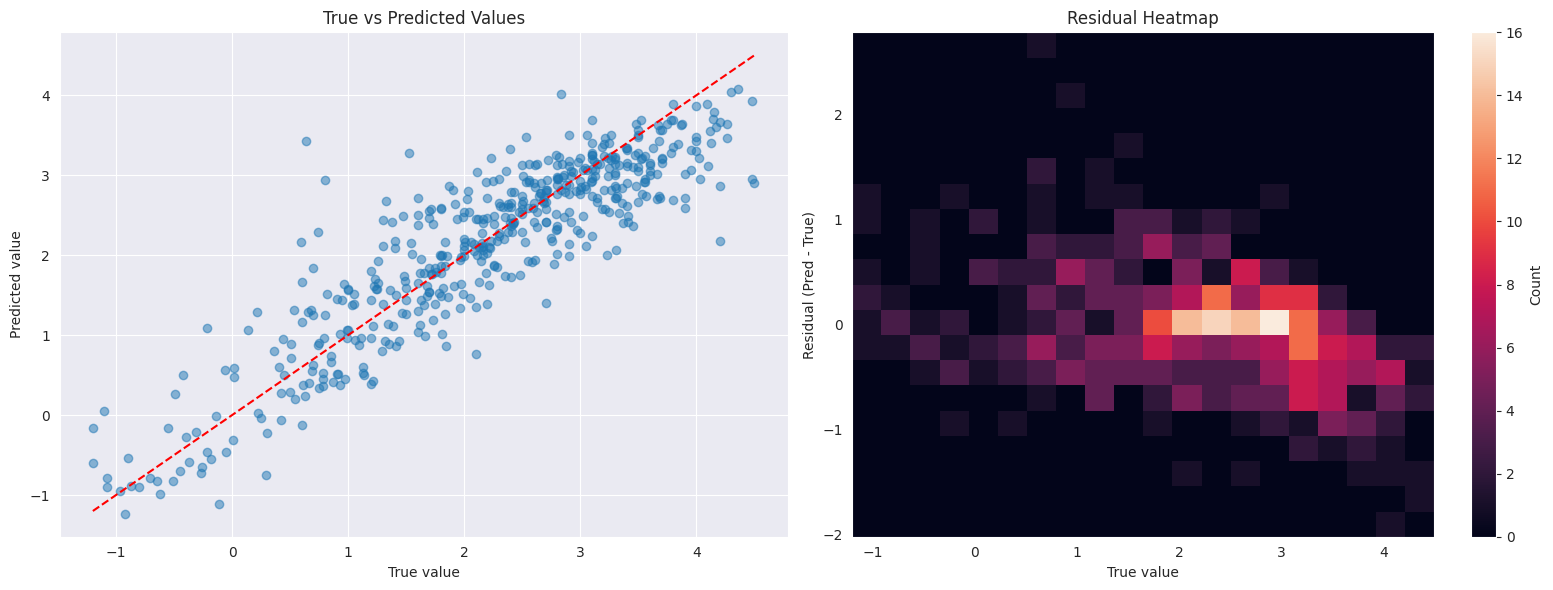

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def test():
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            out = model(data)
            y_hat = out.view(-1)

            y_pred.extend(y_hat.cpu().tolist())
            y_true.extend(data.y.tolist())
    return y_true, y_pred

y_true, y_pred = test()
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")

epochs_data = np.array(y_true).flatten()
pred_data = np.array(y_pred).flatten()

def print_figures(epochs_data, pred_data):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].scatter(epochs_data, pred_data, alpha=0.5)
    axes[0].plot([min(epochs_data), max(epochs_data)], [min(epochs_data), max(epochs_data)], color='red', linestyle='--')
    axes[0].set_xlabel("True value")
    axes[0].set_ylabel("Predicted value")
    axes[0].set_title("True vs Predicted Values")
    axes[0].grid(True)

    residuals = pred_data - epochs_data
    hb = axes[1].hist2d(epochs_data, residuals, bins=20)
    plt.colorbar(hb[3], ax=axes[1], label="Count")
    axes[1].set_xlabel("True value")
    axes[1].set_ylabel("Residual (Pred - True)")
    axes[1].set_title("Residual Heatmap")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

print_figures(epochs_data, pred_data)

# Test

RMSE: 0.6521401883485382


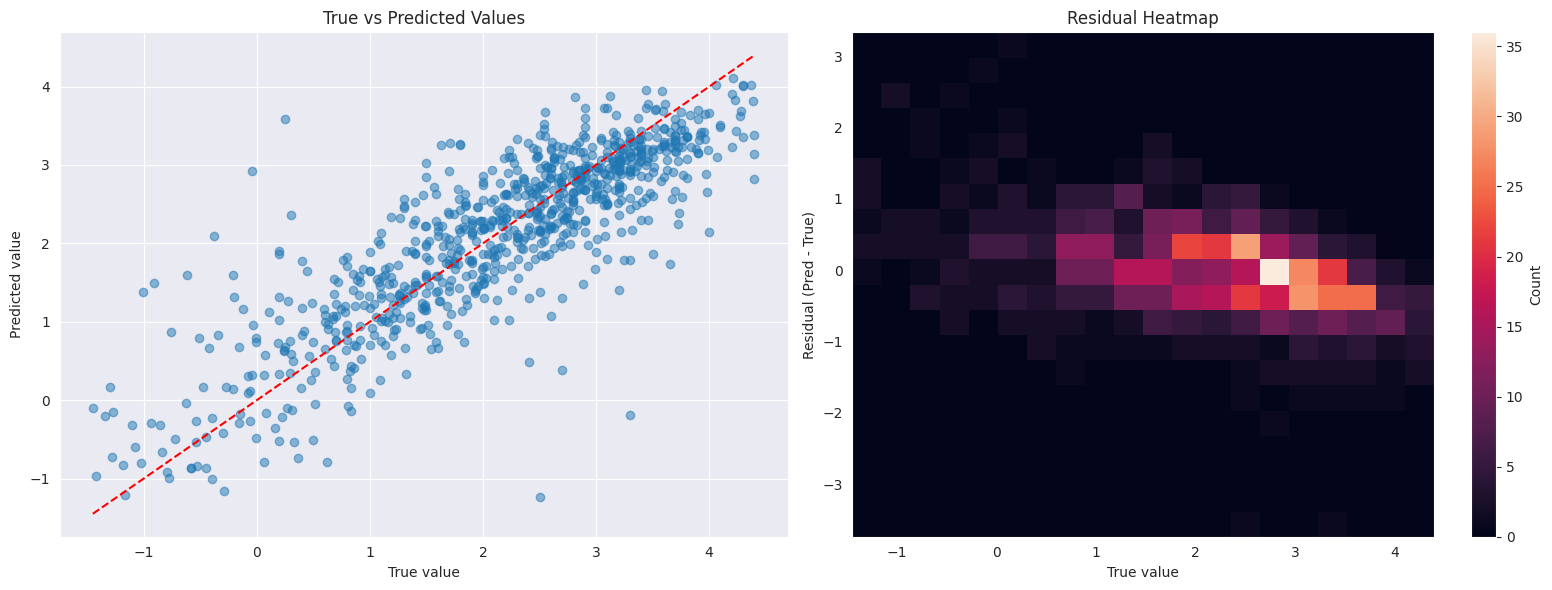

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

model.eval()

url = "https://raw.githubusercontent.com/luciacuevascsv/analisis_redes_sociales/main/Practica%20II/test_labels.csv"
test_labels_df = pd.read_csv(url)
test_labels_dict = dict(zip(test_labels_df['id'], test_labels_df['label']))

y_true = []
y_pred = []

with torch.no_grad():
    for idx in dataset.test_idx:
        data = dataset[idx]
        data = data.to(device)
        out = model(data)
        y_hat = out.view(-1).cpu().item()

        y_pred.append(y_hat)
        y_true.append(test_labels_dict[data.nid.item()])

print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")

y_true_arr = np.array(y_true).flatten()
y_pred_arr = np.array(y_pred).flatten()

print_figures(y_true_arr, y_pred_arr)
